# Import dependencies

In [1]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from tqdm import tqdm

import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Input, Conv1D, BatchNormalization, LeakyReLU, Conv1DTranspose, Flatten, Reshape

In [2]:
batch_size = 50
epochs = 50
pad_trunk_size = 500
count_samples = 4282

# Load & prepare data

In [22]:
def pad_trunc(data, target_size):
    if data.shape[0] < target_size:
        padded_data = np.pad(data, ((0, target_size - data.shape[0]), (0, 0)), mode='constant', constant_values=0.0)
        return padded_data
    elif data.shape[0] > target_size:
        truncated_data = data[:target_size, :]
        return truncated_data
    else:
        return data

In [23]:
def train_generator():
    num_batches = count_samples // batch_size
    indexes = np.arange(count_samples)
    while True:
        np.random.shuffle(indexes)
        inx_batches = np.array_split(indexes, num_batches)
        for inx_batch in inx_batches:
            batch = np.array([
                pad_trunc(
                    pd.read_csv(f"D:/documents/lambda_calc_data/embeddings_4k/term_embeddings_{inx}.csv").drop(columns=['Unnamed: 0']).to_numpy(),
                    pad_trunk_size
                ) 
                for inx in list(inx_batch)
            ])
            yield batch, batch


def data_generator():
    while True:
        for inx in range(count_samples):
            data_sample = np.array([
                pad_trunc(
                    pd.read_csv(f"D:/documents/lambda_calc_data/embeddings_4k/term_embeddings_{inx}.csv").drop(columns=['Unnamed: 0']).to_numpy(),
                    pad_trunk_size
                ),
            ])
            yield data_sample

In [24]:
# Prepare check data (LO-best, RI-best, LO=RI)

all_data = pd.read_csv(
    "../tests_17_ann_and_terms/article_v2_2_term_var_to_best_strategy/prepare_data/data_steps/steps_vars_term_str.csv",
    delimiter=',')

# leave only unique terms
print(f"Count all terms: {len(all_data)}")

print(f"max RI steps count: {max(all_data['RI_steps_num'])}")
print(f"max LO steps count: {max(all_data['LO_steps_num'])}")

# RI == LO -> 0
# RI > LO -> 1
# RI < LO -> 2
class_RI_LO = ["RI = LO" if los == ris else "RI < LO" if ris < los else "LO < RI" for los, ris in
               zip(all_data["LO_steps_num"].tolist(), all_data["RI_steps_num"].tolist())]

print(f"Count terms data samples: {len(class_RI_LO)}")

Count all terms: 4282
max RI steps count: 1000
max LO steps count: 219
Count terms data samples: 4282


# Define & train autoencoder model

In [16]:
class Autoencoder(Model):
    def __init__(self, latent_dim=8000, shape=(500, 768)):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.shape = shape
        self.encoder = tf.keras.Sequential([
            Input(shape=shape, name="encoder_input"),
        
            # Block 1
            Conv1D(filters=256, kernel_size=3, strides=2, padding="same", name="enc_conv_1"),
            BatchNormalization(name="enc_bn_1"),
            LeakyReLU(name="enc_lrelu_1"),
            
            # Block 2
            Conv1D(filters=128, kernel_size=3, strides=1, padding="same", name="enc_conv_2"),
            BatchNormalization(name="enc_bn_2"),
            LeakyReLU(name="enc_lrelu_2"),
        
            # Block 3
            Conv1D(filters=128, kernel_size=3, strides=2, padding="same", name="enc_conv_3"),
            BatchNormalization(name="enc_bn_3"),
            LeakyReLU(name="enc_lrelu_3"),
        
            # Block 4
            Conv1D(filters=128, kernel_size=3, strides=1, padding="same", name="enc_conv_4"),
            BatchNormalization(name="enc_bn_4"),
            LeakyReLU(name="enc_lrelu_4"),
        
            # Block 5
            Conv1D(filters=64, kernel_size=3, strides=1, padding="same", name="enc_conv_5"),
            BatchNormalization(name="enc_bn_5"),
            LeakyReLU(name="enc_lrelu_5"),
        
            Flatten(),
        ], name="encoder")

        self.decoder = tf.keras.Sequential([
            Input(shape=8000, name="decoder_input"),
            Reshape(target_shape=[500, 16], name="dec_reshape"),
        
            # Block 1
            Conv1DTranspose(filters=32, kernel_size=3, strides=1, padding="same", name="dec_conv_transpose_1"),
            BatchNormalization(name='dec_bn_1'),
            LeakyReLU(name='dec_lrelu_1'),
        
            # Block 2
            Conv1DTranspose(filters=64, kernel_size=3, strides=1, padding="same", name="dec_conv_transpose_2"),
            BatchNormalization(name='dec_bn_2'),
            LeakyReLU(name='dec_lrelu_2'),
        
            # Block 3
            Conv1DTranspose(filters=128, kernel_size=3, strides=1, padding="same", name="dec_conv_transpose_3"),
            BatchNormalization(name='dec_bn_3'),
            LeakyReLU(name='dec_lrelu_3'),
            
            # Block 4
            Conv1DTranspose(filters=300, kernel_size=3, strides=1, padding="same", name="dec_conv_transpose_4"),
            BatchNormalization(name='dec_bn_4'),
            LeakyReLU(name='dec_lrelu_4'),
        
            Conv1DTranspose(filters=768, kernel_size=3, strides=1, padding="same", activation="sigmoid",
                            name="dec_conv_transpose_5"),
        ], name="decoder")

    def call(self, inputs, training=None, mask=None):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

In [17]:
autoencoder_model = Autoencoder()
autoencoder_model.compile(optimizer='adam', loss=tf.losses.MeanSquaredError())

In [18]:
autoencoder_model.encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 enc_conv_1 (Conv1D)         (None, 250, 256)          590080    
                                                                 
 enc_bn_1 (BatchNormalizatio  (None, 250, 256)         1024      
 n)                                                              
                                                                 
 enc_lrelu_1 (LeakyReLU)     (None, 250, 256)          0         
                                                                 
 enc_conv_2 (Conv1D)         (None, 250, 128)          98432     
                                                                 
 enc_bn_2 (BatchNormalizatio  (None, 250, 128)         512       
 n)                                                              
                                                                 
 enc_lrelu_2 (LeakyReLU)     (None, 250, 128)          0   

In [19]:
autoencoder_model.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dec_reshape (Reshape)       (None, 500, 16)           0         
                                                                 
 dec_conv_transpose_1 (Conv1  (None, 500, 32)          1568      
 DTranspose)                                                     
                                                                 
 dec_bn_1 (BatchNormalizatio  (None, 500, 32)          128       
 n)                                                              
                                                                 
 dec_lrelu_1 (LeakyReLU)     (None, 500, 32)           0         
                                                                 
 dec_conv_transpose_2 (Conv1  (None, 500, 64)          6208      
 DTranspose)                                                     
                                                           

In [20]:
print("ENC IN:", autoencoder_model.encoder.inputs)
print("ENC OUT:", autoencoder_model.encoder.outputs, "\n")
print("DEC IN:", autoencoder_model.decoder.inputs)
print("DEC OUT:", autoencoder_model.decoder.outputs)

ENC IN: [<KerasTensor: shape=(None, 500, 768) dtype=float32 (created by layer 'encoder_input')>]
ENC OUT: [<KerasTensor: shape=(None, 8000) dtype=float32 (created by layer 'flatten_11')>] 

DEC IN: [<KerasTensor: shape=(None, 8000) dtype=float32 (created by layer 'decoder_input')>]
DEC OUT: [<KerasTensor: shape=(None, 500, 768) dtype=float32 (created by layer 'dec_conv_transpose_5')>]


In [25]:
history = autoencoder_model.fit(
    train_generator(), 
    steps_per_epoch=count_samples // batch_size, 
    epochs=epochs,
    verbose=1,
)

Epoch 1/50
85/85 [==============================] - 222s 3s/step - loss: 0.1437
Epoch 2/50
85/85 [==============================] - 187s 2s/step - loss: 0.1243
Epoch 3/50
85/85 [==============================] - 186s 2s/step - loss: 0.1212
Epoch 4/50
85/85 [==============================] - 197s 2s/step - loss: 0.1200
Epoch 5/50
85/85 [==============================] - 201s 2s/step - loss: 0.1193
Epoch 6/50
85/85 [==============================] - 194s 2s/step - loss: 0.1189
Epoch 7/50
85/85 [==============================] - 204s 2s/step - loss: 0.1186
Epoch 8/50
85/85 [==============================] - 196s 2s/step - loss: 0.1183
Epoch 9/50
85/85 [==============================] - 192s 2s/step - loss: 0.1180
Epoch 10/50
85/85 [==============================] - 195s 2s/step - loss: 0.1178
Epoch 11/50
85/85 [==============================] - 201s 2s/step - loss: 0.1176
Epoch 12/50
85/85 [==============================] - 189s 2s/step - loss: 0.1174
Epoch 13/50
85/85 [==================

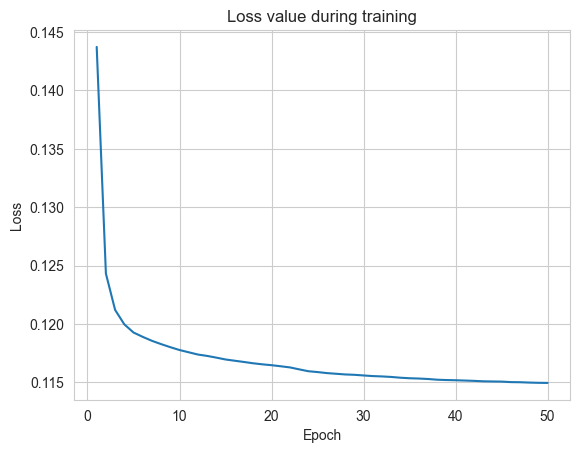

In [27]:
plt.plot(range(1, epochs+1), history.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss value during training")
plt.show()

# Save the model to files

In [28]:
models_path = "./fine_models/autoencoder_v3/"
model_name = "encoder_model"

model_json = autoencoder_model.encoder.to_json()
with open(f"{models_path}{model_name}.json", "w") as json_file:
    json_file.write(model_json)
    
autoencoder_model.encoder.save_weights(f"{models_path}{model_name}.h5")

In [29]:
model_name = "decoder_model"

model_json = autoencoder_model.decoder.to_json()
with open(f"{models_path}{model_name}.json", "w") as json_file:
    json_file.write(model_json)
    
autoencoder_model.decoder.save_weights(f"{models_path}{model_name}.h5")

# Additional testings

In [30]:
encoded_embeddings = autoencoder_model.encoder.predict(data_generator(), steps=4282)

4282/4282 [==============================] - 184s 43ms/step


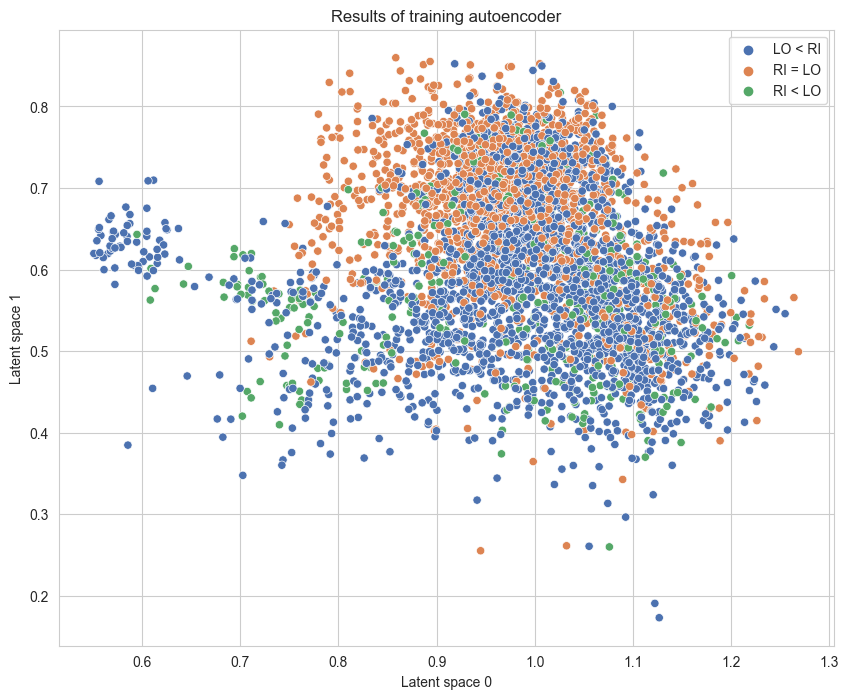

In [31]:
list_ls_0 = [ee[0] for ee in encoded_embeddings]
list_ls_1 = [ee[1] for ee in encoded_embeddings]

encoding_df = pd.DataFrame()
encoding_df["LS0"] = list_ls_0
encoding_df["LS1"] = list_ls_1
encoding_df["class"] = class_RI_LO


plt.figure(figsize=(10, 8))
sns.scatterplot(x='LS0', y='LS1', hue='class', data=encoding_df, palette="deep")
plt.title('Results of training autoencoder')
plt.xlabel('Latent space 0')
plt.ylabel('Latent space 1')
plt.legend()
plt.show()

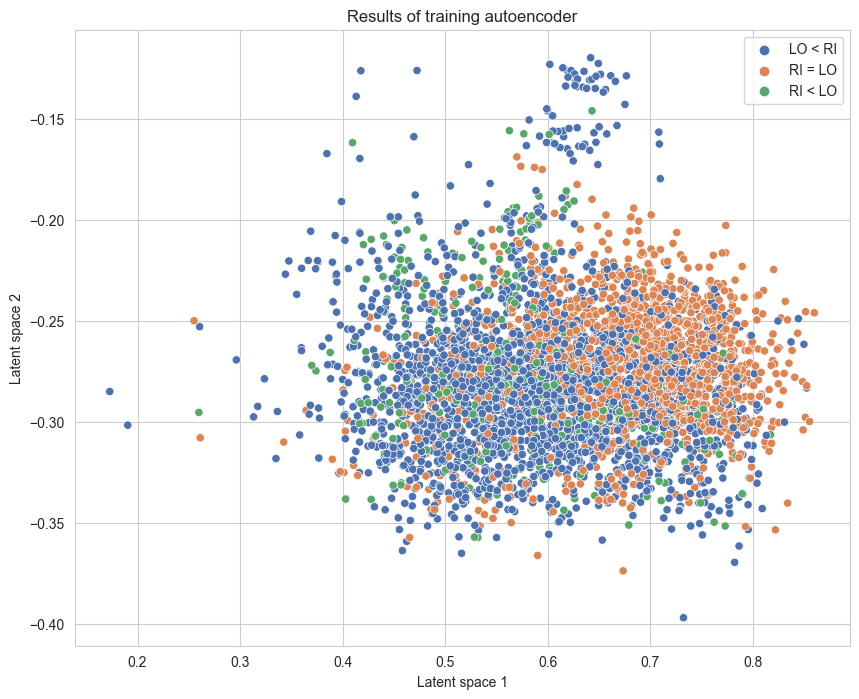

In [32]:
list_ls_1 = [ee[1] for ee in encoded_embeddings]
list_ls_2 = [ee[2] for ee in encoded_embeddings]

encoding_df = pd.DataFrame()
encoding_df["LS1"] = list_ls_1
encoding_df["LS2"] = list_ls_2
encoding_df["class"] = class_RI_LO


plt.figure(figsize=(10, 8))
sns.scatterplot(x='LS1', y='LS2', hue='class', data=encoding_df, palette="deep")
plt.title('Results of training autoencoder')
plt.xlabel('Latent space 1')
plt.ylabel('Latent space 2')
plt.legend()
plt.show()

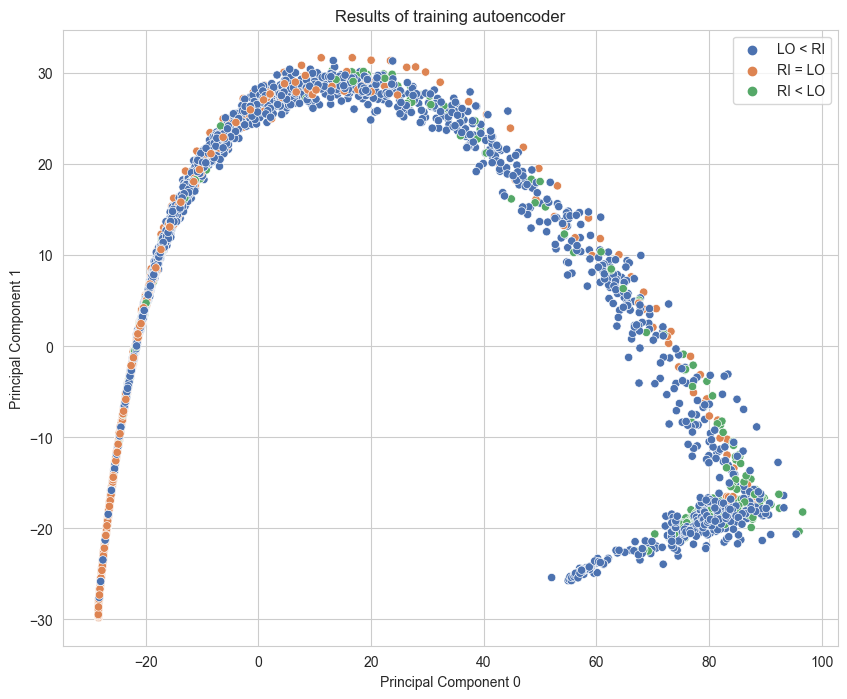

In [33]:
pca_data = PCA(n_components=2).fit_transform(encoded_embeddings)

encoding_df = pd.DataFrame(data=pca_data, columns=['PC0', 'PC1'])
encoding_df["class"] = class_RI_LO


plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC0', y='PC1', hue='class', data=encoding_df, palette="deep")
plt.title('Results of training autoencoder')
plt.xlabel('Principal Component 0')
plt.ylabel('Principal Component 1')
plt.legend()
plt.show()

In [34]:
pca_data = PCA(n_components=3).fit_transform(encoded_embeddings)

tsne_df_3d = pd.DataFrame(data=pca_data, columns=["PC0", "PC1", "PC2"])
tsne_df_3d['class'] = class_RI_LO

fig = px.scatter_3d(
    tsne_df_3d, x='PC0', y='PC1', z='PC2',
    color='class', title=f"3D PCA Latent Space Embeddings",
)

fig.update_traces(marker=dict(size=2))
fig.show()